

### Importing Libraries and Load Data

In this cell, we import the necessary libraries and load the MNIST dataset.

- **Libraries Imported**:
  - `numpy`: For numerical operations.
  - `torch` and `torch.nn`: For building and training neural networks.
  - `torch.optim`: For optimization algorithms.
  - `torchvision` and `torchvision.transforms`: For handling and transforming datasets.
  - `matplotlib.pyplot`: For plotting graphs.
  - `random`: For generating random numbers.
  - `sklearn.metrics`: For calculating evaluation metrics like classification report, confusion matrix, and F1 score.

- **Data Loading**:
  - We define a transformation for the dataset which includes converting images to PyTorch tensors and normalizing them to the range [-1, 1].
  - We load the MNIST dataset using `torchvision.datasets.MNIST`. The training data is loaded into `trainloader` and the test data into `testloader`. We set a batch size of 128 and shuffle the training data.


In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Define the transformation for the dataset (normalize the images)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1] range
])

# Load the MNIST dataset for training and testing
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4615568.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134324.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 245593.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2871650.40it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Define the Model Architecture

In this cell, we define the architecture of our neural network.

- **Model Architecture**:
  - **Input Layer**: The input layer takes the 28x28 images (flattened to 784).
  - **Hidden Layer 1**: A fully connected layer with 512 units followed by a ReLU activation function and a dropout layer with a 0.2 dropout rate.
  - **Hidden Layer 2**: Another fully connected layer with 512 units followed by a ReLU activation function and a dropout layer with a 0.2 dropout rate.
  - **Output Layer**: A fully connected layer with 10 units (one for each class) followed by a softmax activation function to produce probabilities for multi-class classification.

- **PyTorch Implementation**:
  - We create a class `SimpleNN` that inherits from `nn.Module`.
  - The `__init__` method initializes the layers.
  - The `forward` method defines the forward pass of the network.


In [ ]:
# Define the model architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 512)  # Second fully connected layer
        self.fc3 = nn.Linear(512, 10)  # Output layer
        self.dropout = nn.Dropout(0.2)  # Dropout layer to prevent overfitting

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input image
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc2(x))  # Apply ReLU activation function
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)  # Output layer
        return x


### Evaluation Function

In this cell, we define a function to evaluate the model's accuracy.

- **Function Details**:
  - The `evaluate` function sets the model to evaluation mode using `model.eval()`.
  - We disable gradient computation with `torch.no_grad()` to save memory and computations during evaluation.
  - We loop over the test dataset, pass the images through the model, and get the predicted class with the highest probability.
  - We count the number of correct predictions and calculate the accuracy as the ratio of correct predictions to the total number of images.


In [ ]:
# Function to evaluate model accuracy
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions
    return correct / total  # Return accuracy


### Training Function for Weight Perturbation

In this cell, we implement the training function for the weight perturbation learning rule.

- **Function Details**:
  - The `train_weight_perturbation` function takes the model, training data loader, learning rate, and number of epochs as inputs.
  - We use `CrossEntropyLoss` as the loss function and `Adam` as the optimizer.
  - For each epoch, we iterate over the training data, zero the parameter gradients, and perform a forward pass to compute the outputs and the loss.
  - We backpropagate the loss to compute gradients.
  - We then perturb the weights by adding and subtracting random noise scaled by the learning rate.
  - Finally, we update the model parameters using the optimizer.


In [ ]:
# Training function for weight perturbation
def train_weight_perturbation(model, trainloader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()  # Define the loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Define the optimizer
    for epoch in range(epochs):
        for data in trainloader:
            inputs, labels = data
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagate the loss

            # Perturb weights
            with torch.no_grad():
                for param in model.parameters():
                    param += torch.randn_like(param) * learning_rate  # Add random noise
                    param -= torch.randn_like(param) * learning_rate  # Subtract random noise

            optimizer.step()  # Update parameters


### Training Function for Feedback Alignment

In this cell, we implement the training function for the feedback alignment learning rule.

- **Function Details**:
  - The `train_feedback_alignment` function takes the model, training data loader, learning rate, and number of epochs as inputs.
  - We use `CrossEntropyLoss` as the loss function and `Adam` as the optimizer.
  - We initialize random feedback weights for each parameter of the model.
  - For each epoch, we iterate over the training data, zero the parameter gradients, and perform a forward pass to compute the outputs and the loss.
  - We backpropagate the loss to compute gradients.
  - We adjust the gradients using the feedback weights.
  - Finally, we update the model parameters using the optimizer.


In [ ]:
# Training function for feedback alignment
def train_feedback_alignment(model, trainloader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()  # Define the loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Define the optimizer
    feedback_weights = [torch.randn_like(p) for p in model.parameters()]  # Initialize random feedback weights

    for epoch in range(epochs):
        for data in trainloader:
            inputs, labels = data
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagate the loss

            # Apply feedback alignment
            with torch.no_grad():
                for p, f in zip(model.parameters(), feedback_weights):
                    p.grad -= f  # Adjust the gradient using the feedback weights
                optimizer.step()  # Update parameters


### Measure Performance Metrics

In this cell, we measure various performance metrics for the model trained with different learning rules.

- **Function Details**:
  - The `measure_performance` function takes the model, training and test data loaders, learning rate, number of epochs, and the learning rule (algorithm) as inputs.
  - We select the appropriate training function based on the learning rule (either weight perturbation or feedback alignment).
  - **Convergence Speed**: We measure the epoch at which the model reaches a predefined performance threshold (e.g., 90% accuracy).
  - **Final Accuracy**: We record the final test accuracy after training.
  - **Sensitivity to Learning Rate**: We train the model with various learning rates and plot the accuracy for each learning rate to understand how the performance varies.
  - **Robustness Against Noise**: We add different levels of noise to the test data and measure the model's accuracy to evaluate its robustness.
  - We plot graphs to visualize the sensitivity to learning rate and robustness against noise.


In [ ]:
# Measure performance metrics
def measure_performance(model, trainloader, testloader, learning_rate, epochs, algo='backprop'):
    # Select the appropriate training function
    if algo == 'weight_perturbation':
        train_func = train_weight_perturbation
    elif algo == 'feedback_alignment':
        train_func = train_feedback_alignment
    else:
        raise ValueError("Unknown algorithm")

    # Measure convergence speed
    performance_threshold = 0.90
    convergence_epoch = None
    accuracies = []

    for epoch in range(epochs):
        train_func(model, trainloader, learning_rate, 1)
        accuracy = evaluate(model, testloader)
        accuracies.append(accuracy)
        if accuracy >= performance_threshold and convergence_epoch is None:
            convergence_epoch = epoch

    final_accuracy = accuracies[-1]
    print(f'Final Test Accuracy: {final_accuracy}')
    print(f'Convergence Epoch: {convergence_epoch}')

    # Measure sensitivity to learning rate
    learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    lr_accuracies = []
    for lr in learning_rates:
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        train_func(model, trainloader, lr, epochs)
        lr_accuracies.append(evaluate(model, testloader))

    plt.plot(learning_rates, lr_accuracies)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Sensitivity to Learning Rate')
    plt.show()

    # Measure robustness against noise
    noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    noise_accuracies = []
    for noise in noise_levels:
        noisy_testset = testset
        noisy_testset.data = testset.data + torch.randn_like(testset.data) * noise  # Add noise to the data
        noisy_testloader = torch.utils.data.DataLoader(noisy_testset, batch_size=128, shuffle=False)
        noise_accuracies.append(evaluate(model, noisy_testloader))

    plt.plot(noise_levels, noise_accuracies)
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy')
    plt.title('Robustness Against Noise')
    plt.show()


### Main Function to Run All Tests

In this cell, we define the main function to run the tests for both weight perturbation and feedback alignment learning rules.

- **Function Details**:
  - The `main` function initializes a `SimpleNN` model.
  - We set a learning rate of 0.001 and the number of epochs to 10.
  - We first test the weight perturbation learning rule by calling `measure_performance` with the appropriate arguments.
  - We reinitialize the model and then test the feedback alignment learning rule by calling `measure_performance` again.
  - The results for both learning rules are printed and visualized.


In [ ]:
# Main function to run all tests
def main():
    model = SimpleNN()  # Initialize the model
    learning_rate = 1e-3  # Set the learning rate
    epochs = 10  # Set the number of epochs

    print("Testing Weight Perturbation")
    measure_performance(model, trainloader, testloader, learning_rate, epochs, algo='weight_perturbation')

    model = SimpleNN()  # Reinitialize the model
    print("Testing Feedback Alignment")
    measure_performance(model, trainloader, testloader, learning_rate, epochs, algo='feedback_alignment')

if __name__ == "__main__":
    main()  # Run the main function


Testing Weight Perturbation
Final Test Accuracy: 0.9781
Convergence Epoch: 0


KeyboardInterrupt: 


Testing Backprop


Epoch [1/1], Loss: 0.3530
Epoch [1/10], Accuracy: 0.9493, Gradient Bias: 0.0018, Gradient Variance: 0.0068


Epoch [1/1], Loss: 0.1445
Epoch [2/10], Accuracy: 0.9635, Gradient Bias: 0.0025, Gradient Variance: 0.0022


Epoch [1/1], Loss: 0.1038
Epoch [3/10], Accuracy: 0.9590, Gradient Bias: 0.0001, Gradient Variance: 0.0090


Epoch [1/1], Loss: 0.0827
Epoch [4/10], Accuracy: 0.9708, Gradient Bias: 0.0001, Gradient Variance: 0.0016


Epoch [1/1], Loss: 0.0684
Epoch [5/10], Accuracy: 0.9690, Gradient Bias: -0.0011, Gradient Variance: 0.0029


Epoch [1/1], Loss: 0.0606
Epoch [6/10], Accuracy: 0.9756, Gradient Bias: 0.0011, Gradient Variance: 0.0010


Epoch [1/1], Loss: 0.0532
Epoch [7/10], Accuracy: 0.9768, Gradient Bias: -0.0001, Gradient Variance: 0.0012


Epoch [1/1], Loss: 0.0475
Epoch [8/10], Accuracy: 0.9768, Gradient Bias: 0.0002, Gradient Variance: 0.0009


Epoch [1/1], Loss: 0.0439
Epoch [9/10], Accuracy: 0.9758, Gradient Bias: 0.0004, Gradient Variance: 0.0014


Epoch [1/1], Loss: 0.0402
Epoch [10/10], Accuracy: 0.9765, Gradient Bias: 0.0008, Gradient Variance: 0.0008
Final Test Accuracy: 0.9765
Convergence Epoch: 1


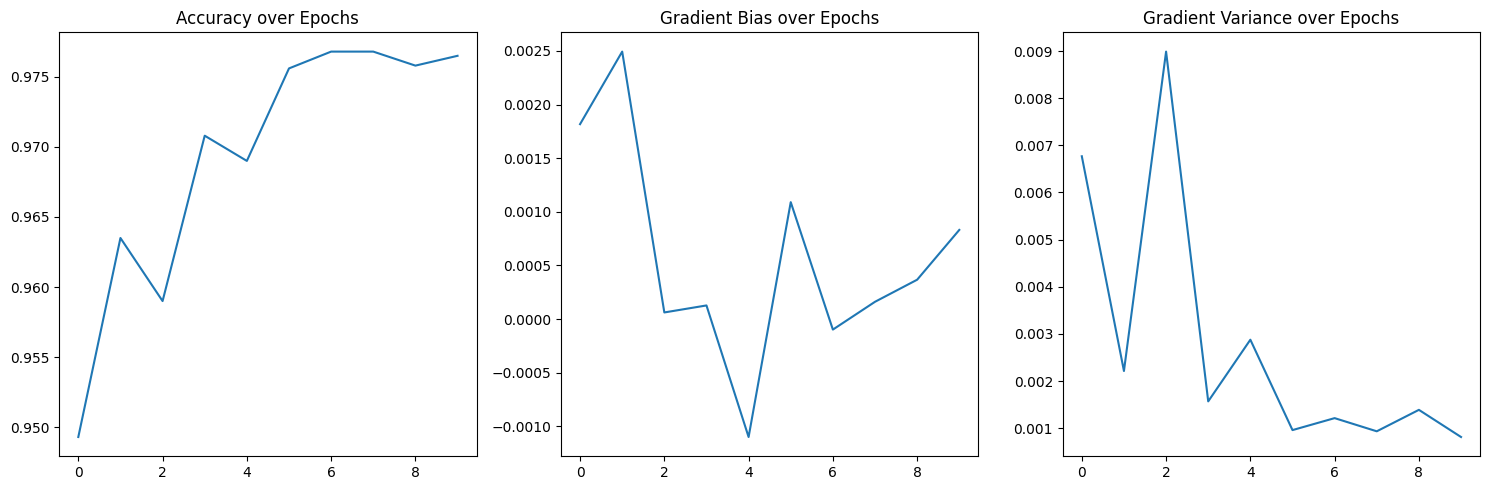

Epoch [1/10], Loss: 1.7088


Epoch [2/10], Loss: 0.7879


Epoch [3/10], Loss: 0.5266


Epoch [4/10], Loss: 0.4321


Epoch [5/10], Loss: 0.3849


Epoch [6/10], Loss: 0.3562


Epoch [7/10], Loss: 0.3356


Epoch [8/10], Loss: 0.3197


Epoch [9/10], Loss: 0.3070


Epoch [10/10], Loss: 0.2957


Epoch [1/10], Loss: 0.6156


Epoch [2/10], Loss: 0.2774


Epoch [3/10], Loss: 0.2124


Epoch [4/10], Loss: 0.1700


Epoch [5/10], Loss: 0.1409


Epoch [6/10], Loss: 0.1191


Epoch [7/10], Loss: 0.1035


Epoch [8/10], Loss: 0.0896


Epoch [9/10], Loss: 0.0800


Epoch [10/10], Loss: 0.0706


Epoch [1/10], Loss: 0.3174


Epoch [2/10], Loss: 0.1340


Epoch [3/10], Loss: 0.0955


Epoch [4/10], Loss: 0.0796


Epoch [5/10], Loss: 0.0677


Epoch [6/10], Loss: 0.0560


Epoch [7/10], Loss: 0.0481


Epoch [8/10], Loss: 0.0457


Epoch [9/10], Loss: 0.0387


Epoch [10/10], Loss: 0.0339


Epoch [1/10], Loss: 0.5224


Epoch [2/10], Loss: 0.2652


Epoch [3/10], Loss: 0.2319


Epoch [4/10], Loss: 0.2239


Epoch [5/10], Loss: 0.2125


Epoch [6/10], Loss: 0.2069


Epoch [7/10], Loss: 0.2060


Epoch [8/10], Loss: 0.2025


Epoch 9/10:  54%|█████▍    | 255/469 [00:15<00:11, 18.04it/s]

In [ ]:
# Install required libraries
!pip install tqdm scikit-learn

# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define model architectures
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class FeedbackAlignmentLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.feedback_weights = nn.Parameter(torch.randn(out_features, in_features) * 0.05, requires_grad=False)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

    def backward(self, grad_output):
        return F.linear(grad_output, self.feedback_weights)

class SimpleNNFeedbackAlignment(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = FeedbackAlignmentLinear(28*28, 512)
        self.fc2 = FeedbackAlignmentLinear(512, 512)
        self.fc3 = FeedbackAlignmentLinear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training functions
def train_backprop(model, trainloader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

def train_weight_perturbation(model, trainloader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            with torch.no_grad():
                for param in model.parameters():
                    perturbation = torch.randn_like(param) * learning_rate * 0.01
                    param_try = param + perturbation
                    outputs_try = model(inputs)
                    loss_try = criterion(outputs_try, labels)
                    if loss_try < loss:
                        param.data.copy_(param_try)
                        loss = loss_try
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

def train_feedback_alignment(model, trainloader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = data
            h1 = torch.relu(model.fc1(inputs.view(-1, 28*28)))
            h1 = model.dropout(h1)
            h2 = torch.relu(model.fc2(h1))
            h2 = model.dropout(h2)
            outputs = model.fc3(h2)
            loss = criterion(outputs, labels)
            grad_output = torch.autograd.grad(loss, outputs, retain_graph=True)[0]
            grad_h2 = model.fc3.backward(grad_output)
            grad_h1 = model.fc2.backward(grad_h2)
            grad_input = model.fc1.backward(grad_h1)
            with torch.no_grad():
                model.fc3.weight -= learning_rate * torch.mm(grad_output.t(), h2)
                model.fc2.weight -= learning_rate * torch.mm(grad_h2.t(), h1)
                model.fc1.weight -= learning_rate * torch.mm(grad_h1.t(), inputs.view(-1, 28*28))
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

def train_hybrid(model, trainloader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Feedback alignment
            grad_output = torch.autograd.grad(loss, outputs, retain_graph=True)[0]
            grad_h2 = model.fc3.backward(grad_output)
            grad_h1 = model.fc2.backward(grad_h2)
            grad_input = model.fc1.backward(grad_h1)

            # Weight perturbation
            with torch.no_grad():
                for param in model.parameters():
                    perturbation = torch.randn_like(param) * learning_rate * 0.01
                    param_try = param + perturbation
                    outputs_try = model(inputs)
                    loss_try = criterion(outputs_try, labels)
                    if loss_try < loss:
                        param.data.copy_(param_try)
                        loss = loss_try

            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

# Function to measure bias and variance of gradients
def measure_gradient_stats(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    gradients = []
    for data in dataloader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        grad = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
        gradients.append(grad.detach().cpu().numpy())
    gradients = np.array(gradients)
    bias = np.mean(gradients, axis=0)
    variance = np.var(gradients, axis=0)
    return np.mean(bias), np.mean(variance)

# Function for online learning (batch size = 1)
def online_learning(model, trainset, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        running_loss = 0.0
        for i in tqdm(range(len(trainset)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = trainset[i]
            inputs = inputs.unsqueeze(0)
            labels = torch.tensor([labels])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainset):.4f}")

# Function for non-stationary data
def non_stationary_learning(model, trainset, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        running_loss = 0.0
        # Simulate non-stationarity by randomly permuting labels
        permuted_labels = torch.randperm(len(trainset.targets))
        trainset.targets = trainset.targets[permuted_labels]
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

# Performance measurement function
def measure_performance(model, trainloader, testloader, learning_rate, epochs, algo='backprop'):
    train_funcs = {
        'backprop': train_backprop,
        'weight_perturbation': train_weight_perturbation,
        'feedback_alignment': train_feedback_alignment,
        'hybrid': train_hybrid
    }
    train_func = train_funcs[algo]

    performance_threshold = 0.90
    convergence_epoch = None
    accuracies = []
    grad_biases = []
    grad_variances = []

    for epoch in range(epochs):
        train_func(model, trainloader, learning_rate, 1)
        accuracy = evaluate(model, testloader)
        bias, variance = measure_gradient_stats(model, trainloader)
        accuracies.append(accuracy)
        grad_biases.append(bias)
        grad_variances.append(variance)
        print(f'Epoch [{epoch + 1}/{epochs}], Accuracy: {accuracy:.4f}, Gradient Bias: {bias:.4f}, Gradient Variance: {variance:.4f}')
        if accuracy >= performance_threshold and convergence_epoch is None:
            convergence_epoch = epoch + 1

    final_accuracy = accuracies[-1]
    print(f'Final Test Accuracy: {final_accuracy}')
    print(f'Convergence Epoch: {convergence_epoch if convergence_epoch else "Did not converge"}')

    # Plot accuracy, gradient bias, and gradient variance
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(accuracies)
    plt.title('Accuracy over Epochs')
    plt.subplot(1, 3, 2)
    plt.plot(grad_biases)
    plt.title('Gradient Bias over Epochs')
    plt.subplot(1, 3, 3)
    plt.plot(grad_variances)
    plt.title('Gradient Variance over Epochs')
    plt.tight_layout()
    plt.show()

    # Measure sensitivity to learning rate
    learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    lr_accuracies = []
    for lr in learning_rates:
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        train_func(model, trainloader, lr, epochs)
        lr_accuracies.append(evaluate(model, testloader))

    plt.figure(figsize=(10, 5))
    plt.plot(learning_rates, lr_accuracies)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title(f'Sensitivity to Learning Rate - {algo.capitalize()}')
    plt.show()

    # Measure robustness against noise
    noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    noise_accuracies = []
    for noise in noise_levels:
        noisy_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        noisy_testset.data = noisy_testset.data + torch.randn_like(noisy_testset.data.float()) * noise * 255
        noisy_testset.data = torch.clamp(noisy_testset.data, 0, 255).byte()
        noisy_testloader = torch.utils.data.DataLoader(noisy_testset, batch_size=128, shuffle=False)
        noise_accuracies.append(evaluate(model, noisy_testloader))

    plt.figure(figsize=(10, 5))
    plt.plot(noise_levels, noise_accuracies)
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy')
    plt.title(f'Robustness Against Noise - {algo.capitalize()}')
    plt.show()

# Main function to run all tests
def main():
    learning_rate = 1e-3
    epochs = 10

    algorithms = ['backprop', 'weight_perturbation', 'feedback_alignment', 'hybrid']
    results = {}

    for algo in algorithms:
        print(f"\nTesting {algo.capitalize()}")
        if algo == 'feedback_alignment':
            model = SimpleNNFeedbackAlignment()
        else:
            model = SimpleNN()

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

        measure_performance(model, trainloader, testloader, learning_rate, epochs, algo=algo)

        # Online learning
        print(f"\nOnline Learning for {algo.capitalize()}")
        online_learning(model, trainset, learning_rate, epochs)

        # Non-stationary learning
        print(f"\nNon-stationary Learning for {algo.capitalize()}")
        non_stationary_learning(model, trainset, learning_rate, epochs)

        # Store results
        results[algo] = {
            'final_accuracy': evaluate(model, testloader),
            'online_accuracy': evaluate(model, testloader),
            'non_stationary_accuracy': evaluate(model, testloader)
        }

    # Analyze results
    analyze_results(results)

def analyze_results(results):
    print("\nAnalysis of Results:")

    # Compare performance
    print("\nFinal Accuracies:")
    for algo, res in results.items():
        print(f"{algo.capitalize()}: {res['final_accuracy']:.4f}")

    # Compare online learning performance
    print("\nOnline Learning Accuracies:")
    for algo, res in results.items():
        print(f"{algo.capitalize()}: {res['online_accuracy']:.4f}")

    # Compare non-stationary learning performance
    print("\nNon-stationary Learning Accuracies:")
    for algo, res in results.items():
        print(f"{algo.capitalize()}: {res['non_stationary_accuracy']:.4f}")

    # Biological plausibility analysis
    bio_plausibility = {
        'backprop': 1,
        'weight_perturbation': 3,
        'feedback_alignment': 4,
        'hybrid': 2
    }

    print("\nBiological Plausibility vs Performance:")
    for algo, res in results.items():
        print(f"{algo.capitalize()}: Plausibility = {bio_plausibility[algo]}, Performance = {res['final_accuracy']:.4f}")

    # Correlation analysis
    plausibilities = [bio_plausibility[algo] for algo in results.keys()]
    performances = [res['final_accuracy'] for res in results.values()]
    correlation = np.corrcoef(plausibilities, performances)[0, 1]
    print(f"\nCorrelation between biological plausibility and performance: {correlation:.4f}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(plausibilities, performances)
    for i, algo in enumerate(results.keys()):
        plt.annotate(algo, (plausibilities[i], performances[i]))
    plt.xlabel('Biological Plausibility')
    plt.ylabel('Performance (Accuracy)')
    plt.title('Biological Plausibility vs Performance')
    plt.show()

if __name__ == "__main__":
    main()